# Exploring Regression with TPOT

In [1]:
!pip install tpot

     |████████████████████████████████| 87 kB 2.4 MB/s 
     |████████████████████████████████| 192.9 MB 61 kB/s 
     |████████████████████████████████| 160 kB 25.9 MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=7b1a5ad7d85cd1712fb02ea82010ed29a55d5899d2b1cb35128a9c998c086816
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


# Applying automated regression modeling to the fish market dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

In [3]:
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False



In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-Automation-with-TPOT/main/Chapter03/data/Fish.csv")
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [5]:
#Checking for any missing values

df.isnull().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

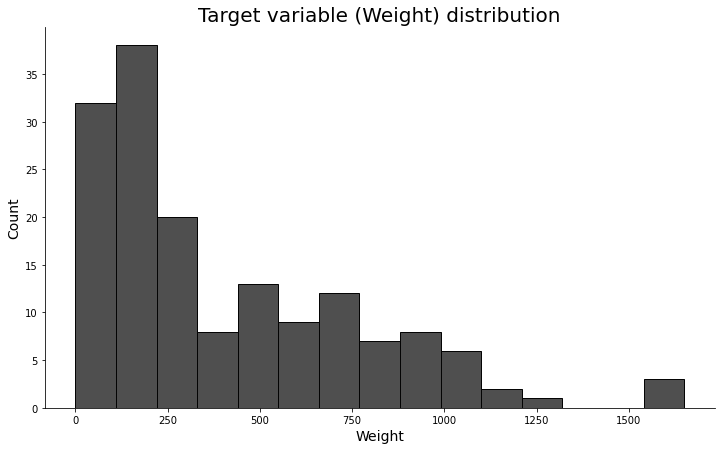

In [6]:
#checking how the target variable is distributed using a histogram

plt.figure(figsize=(12,7))
plt.title("Target variable (Weight) distribution",size=20)
plt.xlabel("Weight",size=14)
plt.ylabel("Count",size=14)
plt.hist(df["Weight"],bins=15,color="#4f4f4f",ec="#040404");

In [7]:
#Printing how many instsances of a specific species there are and also the avg and standard deviation for every attribute

def describe_species(species):
  subset = df[df["Species"] == species]
  print(f"========================{species.upper()}===========================")
  print(f"Count: {len(subset)}")
  print(f"Pct. total: {(len(subset)/len(df) * 1000):.2f}%")
  for column in df.columns[1:]:
    avg = np.round(subset[column].mean(),2)
    sd = np.round(subset[column].std(),2)
    print(f"Avg. {column:>7}: {avg:6} +/- {sd:6}")

for species in df["Species"].unique():
  describe_species(species)
  print()

========================BREAM===========================
Count: 35
Pct. total: 220.13%
Avg.  Weight: 617.83 +/- 209.21
Avg. Length1:  30.31 +/-   3.59
Avg. Length2:  33.11 +/-   3.91
Avg. Length3:  38.35 +/-   4.16
Avg.  Height:  15.18 +/-   1.96
Avg.   Width:   5.43 +/-   0.72

========================ROACH===========================
Count: 20
Pct. total: 125.79%
Avg.  Weight: 152.05 +/-  88.83
Avg. Length1:  20.65 +/-   3.46
Avg. Length2:  22.28 +/-   3.65
Avg. Length3:  24.97 +/-   4.03
Avg.  Height:   6.69 +/-   1.26
Avg.   Width:   3.66 +/-   0.69

========================WHITEFISH===========================
Count: 6
Pct. total: 37.74%
Avg.  Weight:  531.0 +/-  309.6
Avg. Length1:   28.8 +/-   5.58
Avg. Length2:  31.32 +/-   5.72
Avg. Length3:  34.32 +/-   6.02
Avg.  Height:  10.03 +/-   1.83
Avg.   Width:   5.47 +/-   1.19

========================PARKKI===========================
Count: 11
Pct. total: 69.18%
Avg.  Weight: 154.82 +/-  78.76
Avg. Length1:  18.73 +/-   3.28
Avg. Le

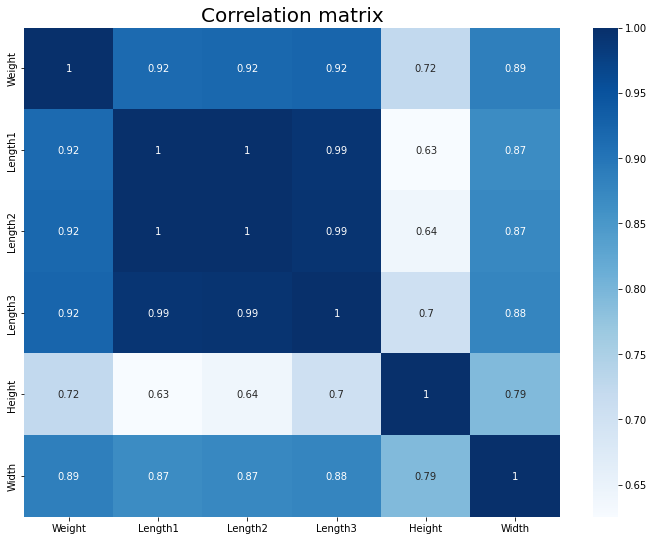

In [8]:
# checking for correlation between attributes. Correlation can be calculated only for numerical attributes

plt.figure(figsize=(12,9))
plt.title("Correlation matrix",size=20)
sns.heatmap(df.corr(),annot=True,cmap="Blues");

In [9]:
# Converting non-numerical attributes to dummy variables

species_dummies = pd.get_dummies(df["Species"],drop_first=True,prefix="Is")
df = pd.concat([species_dummies,df],axis=1)
df.drop("Species",axis=1,inplace=True)
df.head()

,Is_Parkki,Is_Perch,Is_Pike,Is_Roach,Is_Smelt,Is_Whitefish,Weight,Length1,Length2,Length3,Height,Width
0,0,0,0,0,0,0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,0,0,0,0,0,0,290.0,24.0,26.3,31.2,12.4800,4.3056
2,0,0,0,0,0,0,340.0,23.9,26.5,31.1,12.3778,4.6961
3,0,0,0,0,0,0,363.0,26.3,29.0,33.5,12.7300,4.4555
4,0,0,0,0,0,0,430.0,26.5,29.0,34.0,12.4440,5.1340


In [10]:
#importing TPOT and configuring the scoring metrics

from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
rmse = lambda y,y_hat: np.sqrt(mean_squared_error(y,y_hat))

In [11]:
# spliting the data using train test split. Keeping 75% of the data for training and evaluate on the rest

X =  df.drop("Weight",axis=1)
y = df["Weight"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [12]:
#making a baseline model using sklearn LinearRegression

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
lm_preds = lm.predict(X_test)
rmse(y_test,lm_preds)

82.1070951998749

In [13]:
#fitting a TPOT pipeline optimization model using the rmse scorer

rmse_scorer = make_scorer(rmse,greater_is_better=False)
pipeline_optimizer = TPOTRegressor(
    scoring=rmse_scorer,
    max_time_mins=10,
    random_state=42
)

pipeline_optimizer.fit(X_train,y_train)

TPOTRegressor(max_time_mins=10, random_state=42,
              scoring=make_scorer(<lambda>, greater_is_better=False))

In [14]:
#obtaining the RMSE score

pipeline_optimizer.score(X_test,y_test)

-62.97200269664117

# Applying automated regression modeling to the insurance dataset

In [15]:
#obtaining the insurance dataset

df = pd.read_csv("https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-Automation-with-TPOT/main/Chapter03/data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [16]:
#Checking for missing values

df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

(array([382., 294., 258.,  87.,  78.,  50.,  32.,  18.,  44.,  41.,  30.,
         18.,   2.,   1.,   3.]),
 array([ 1121.8739  ,  5298.444174,  9475.014448, 13651.584722,
        17828.154996, 22004.72527 , 26181.295544, 30357.865818,
        34534.436092, 38711.006366, 42887.57664 , 47064.146914,
        51240.717188, 55417.287462, 59593.857736, 63770.42801 ]),
 <a list of 15 Patch objects>)

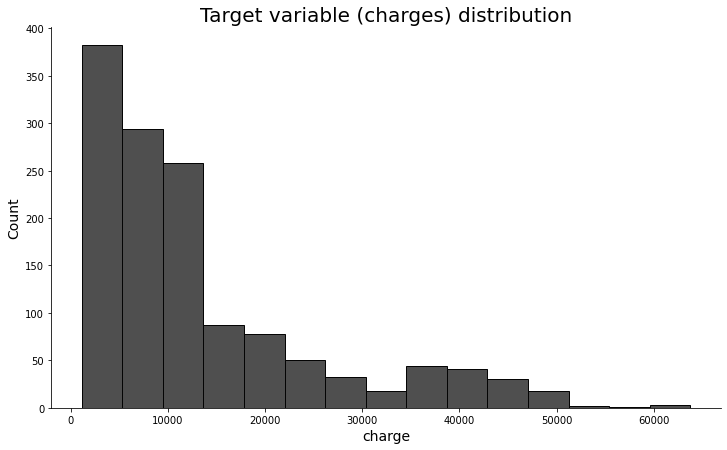

In [17]:
#inspecting the target variable of charges to see the distribution

plt.figure(figsize=(12,7))
plt.title("Target variable (charges) distribution",size=20)
plt.xlabel("charge",size=14)
plt.ylabel("Count",size=14)
plt.hist(df["charges"],bins=15,color="#4f4f4f",ec="#040404")

In [18]:
def make_bar_chart(column,title,ylabel,xlabel,y_offset=0.12,x_offset=700):
  ax = df.groupby(column).median()[["charges"]].plot(
      kind="bar", figsize=(10,6),fontsize=13,color="#4f4f4f"
  )
  ax.set_title(title,size=20,pad=30)
  ax.set_ylabel(ylabel,fontsize=14)
  ax.set_xlabel(xlabel,fontsize=14)
  ax.get_legend().remove()

  for i in ax.patches:
    ax.text(i.get_x() + x_offset,i.get_height() + y_offset,f"${str(round(i.get_height(),2))}",fontsize=15)
  
  return ax

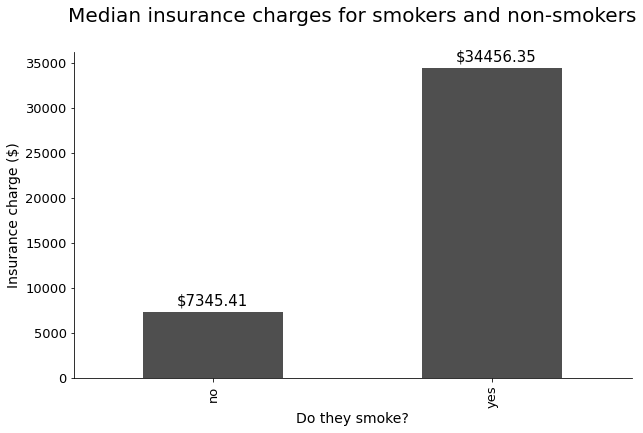

In [19]:
#using the function above to visualize the median insurance cost for smokers and non-smokers
make_bar_chart(
    column = "smoker",
    title = "Median insurance charges for smokers and non-smokers",
    ylabel ="Insurance charge ($)",
    xlabel = "Do they smoke?",
    y_offset=700,
    x_offset=0.12
)

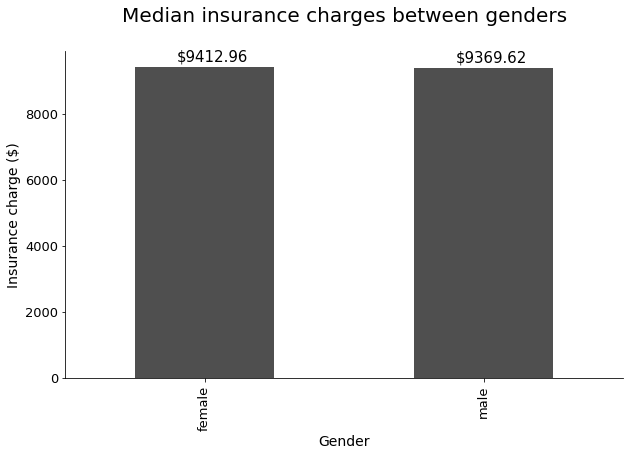

In [20]:
#similar chart for comparing median insurance costs between genders

make_bar_chart(
    column="sex",
    title = "Median insurance charges between genders",
    ylabel="Insurance charge ($)",
    xlabel="Gender",
    y_offset=200,
    x_offset=0.15
)

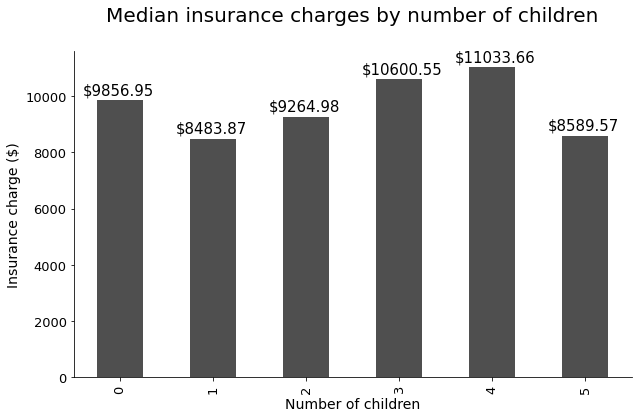

In [21]:
#similar chart for comparing median insurance costs by the number kids

make_bar_chart(
    column = "children",
    title ="Median insurance charges by number of children",
    ylabel = "Insurance charge ($)",
    xlabel = "Number of children",
    y_offset=200,
    x_offset=-0.15
)

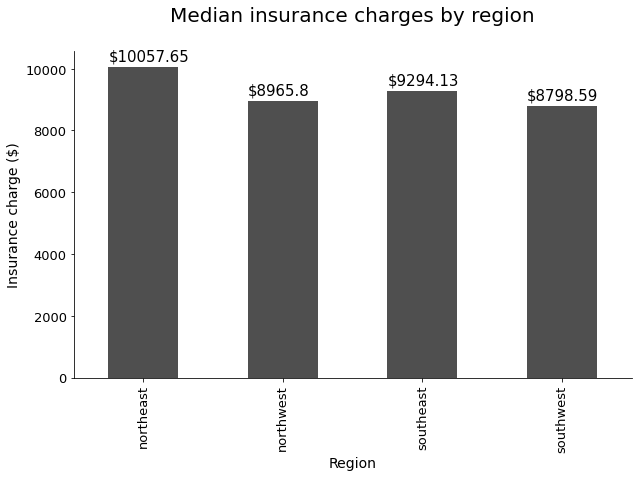

In [22]:
#showing insurance costs by region

make_bar_chart(
    column = "region",
    title = "Median insurance charges by region",
    ylabel = "Insurance charge ($)",
    xlabel = "Region",
    y_offset=200,
    x_offset=0
)

In [23]:
#mapping string values to integers and creating dummy values for the region col.


df["sex"] = [1 if x == "female" else 0 for x in df["sex"]]
df.rename(columns={"sex": "is_female"},inplace=True)
df["smoker"] = [1 if x == "yes" else 0  for x in df["smoker"]]
region_dummies = pd.get_dummies(df["region"], drop_first=True,prefix="region")
df = pd.concat([region_dummies,df],axis=1)
df.drop("region",axis=1,inplace=True)
df.head()

,region_northwest,region_southeast,region_southwest,age,is_female,bmi,children,smoker,charges
0,0,0,1,19,1,27.900,0,1,16884.92400
1,0,1,0,18,0,33.770,1,0,1725.55230
2,0,1,0,28,0,33.000,3,0,4449.46200
3,1,0,0,33,0,22.705,0,0,21984.47061
4,1,0,0,32,0,28.880,0,0,3866.85520


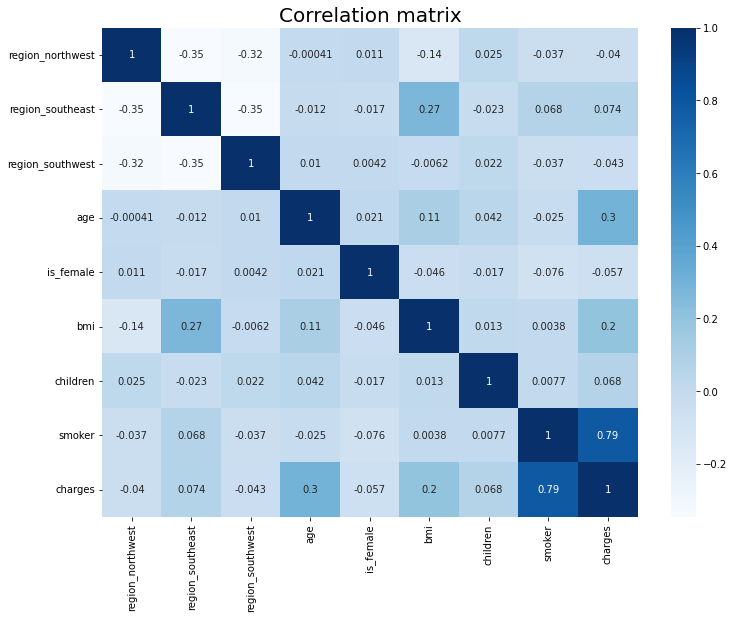

In [24]:
#checking variable correlations

plt.figure(figsize=(12,9))
plt.title("Correlation matrix",size=20)
sns.heatmap(df.corr(),annot=True,cmap="Blues");

In [25]:
#splitting the data into train/test 

X = df.drop("charges",axis=1)
y = df["charges"]
X_train,X_test, y_train,y_test = train_test_split(
    X,y, test_size=0.25,random_state=42
)
y_train.shape,y_test.shape

((1003,), (335,))

In [26]:
#creating a baseline mode using sklearn LinearRegression

from sklearn.metrics import r2_score, mean_squared_error
rmse = lambda y, y_hat: np.sqrt(mean_squared_error(y,y_hat))
lm = LinearRegression()
lm.fit(X_train,y_train)
lm_preds = lm.predict(X_test)
print(f"R2 = {r2_score(y_test,lm_preds):.2f}")
print(f"RMSE = {rmse(y_test,lm_preds):.2f}")

R2 = 0.77
RMSE = 5926.02


In [27]:
#The R2 means the model captures 77% of the variance in the dataset and rmse for this model means that it's off by $5,926.02 

In [28]:
#now using TPOT to produce an automated machine learning pipeline

from tpot import TPOTRegressor

pipeline_optimizer = TPOTRegressor(
    scoring = "r2",
    max_time_mins=10,
    random_state=42,
    verbosity=2
)

pipeline_optimizer.fit(X_train,y_train)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8506515769036094

Generation 2 - Current best internal CV score: 0.8506515769036094

Generation 3 - Current best internal CV score: 0.8506515769036094

Generation 4 - Current best internal CV score: 0.8509056832597235

Generation 5 - Current best internal CV score: 0.8530793152113862

Generation 6 - Current best internal CV score: 0.8530793152113862

10.00 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(ElasticNetCV(CombineDFs(input_matrix, input_matrix), l1_ratio=0.25, tol=0.1), bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=14, min_samples_split=9, n_estimators=100)


TPOTRegressor(max_time_mins=10, random_state=42, scoring='r2', verbosity=2)

In [29]:
#obtaining the R2 score 

pipeline_optimizer.score(X_test,y_test)

0.8638166242477663

In [30]:
#obtaining the R2 and rmse for the test set
tpot_preds = pipeline_optimizer.predict(X_test)
print(f"R2 = {r2_score(y_test,tpot_preds):.2f}")
print(f"RMSE = {rmse(y_test,tpot_preds):.2f}")

R2 = 0.86
RMSE = 4533.09


# Applying automated regression modeling to the vehicle dataset

In [32]:
#dataset : https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-Automation-with-TPOT/main/Chapter03/data/Car.csv

df = pd.read_csv("https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-Automation-with-TPOT/main/Chapter03/data/Car.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [33]:
#checking for missing items

df.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [34]:
#removing the rolls with missing values

df.dropna(inplace=True)
df.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64

In [35]:
#function to remap the owner col. to integer

def remap_owner(owner):
  if owner == "First Owner": return 1
  elif owner == "Second Owner": return 2
  elif owner == "Third Owner": return 3
  elif owner == "Fourth & Above Owner": return 4
  else: return 0

In [36]:
#performing the rest of the transformations

df['transmission'] = [1 if x == 'Manual' else 0 for x in df['transmission']]
df.rename(columns={'transmission': 'is_manual'}, inplace=True)
df['owner'] = df['owner'].apply(remap_owner)
df['name'] = df['name'].apply(lambda x: x.split()[0])
df['mileage'] = df['mileage'].apply(lambda x: x.split()[0]).astype(float)
df['engine'] = df['engine'].apply(lambda x: x.split()[0]).astype(int)
df['max_power'] = df['max_power'].apply(lambda x: x.split()[0]).astype(float)
brand_dummies = pd.get_dummies(df['name'], drop_first=True, prefix='brand')
fuel_dummies = pd.get_dummies(df['fuel'], drop_first=True, prefix='fuel')
seller_dummies = pd.get_dummies(df['seller_type'], drop_first=True, prefix='seller')
df.drop(['name', 'fuel', 'seller_type', 'torque'], axis=1, inplace=True)
df = pd.concat([df, brand_dummies, fuel_dummies, seller_dummies], axis=1)

In [37]:
df.head()

,year,selling_price,km_driven,is_manual,owner,mileage,engine,max_power,seats,brand_Ashok,...,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_Individual,seller_Trustmark Dealer
0,2014,450000,145500,1,1,23.40,1248,74.00,5.0,0,...,0,0,0,0,0,1,0,0,1,0
1,2014,370000,120000,1,2,21.14,1498,103.52,5.0,0,...,1,0,0,0,0,1,0,0,1,0
2,2006,158000,140000,1,3,17.70,1497,78.00,5.0,0,...,0,0,0,0,0,0,0,1,1,0
3,2010,225000,127000,1,1,23.00,1396,90.00,5.0,0,...,0,0,0,0,0,1,0,0,1,0
4,2007,130000,120000,1,1,16.10,1298,88.20,5.0,0,...,0,0,0,0,0,0,0,1,1,0


In [38]:
#spliting the data into train/test 

X = df.drop("selling_price",axis=1)
y = df["selling_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.25,random_state=42
)
y_train.shape,y_test.shape

((5929,), (1977,))

In [39]:
#implementing mean absolute percentage error

def mape(y,y_hat):
  y,y_hat = np.array(y), np.array(y_hat)
  return np.mean(np.abs((y - y_hat)/y)) * 100

In [40]:
#building a baseline model

lm = LinearRegression()
lm.fit(X_train,y_train)
lm_preds = lm.predict(X_test)
print(f"R2 = {r2_score(y_test,lm_preds):.2f}")
print(f"MAPE = {mape(y_test,lm_preds):.2f}")

R2 = 0.87
MAPE = 42.87


In [42]:
#setting up the TPOT pipeline

mape_scorer = make_scorer(mape, greater_is_better=False)
pipeline_optimizer = TPOTRegressor(
    scoring=mape_scorer,
    max_time_mins=10,
    random_state = 42,
    verbosity=2,
    n_jobs=-1
)

pipeline_optimizer.fit(X_train,y_train)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


10.09 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=1, min_samples_split=5, n_estimators=100)


TPOTRegressor(max_time_mins=10, n_jobs=-1, random_state=42,
              scoring=make_scorer(mape, greater_is_better=False), verbosity=2)

In [43]:
#checking the mape and R2 score of the TPOT model

tpot_preds = pipeline_optimizer.predict(X_test)
print(f"R2 = {r2_score(y_test,tpot_preds):.2f}")
print(f"MAPE = {mape(y_test,tpot_preds):.2f}")

R2 = 0.98
MAPE = 14.52
